**Librerias**

In [1]:
import pandas as pd
import sys
import os
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
load_dotenv()
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
from utils.data import divideData
from utils.model import tuneHyperparameters
from utils.evaluate import modelEvaluation, modelEvaluationWithThreshold

**Cargar datos procesados**

In [3]:
READ_DATA_PATH = os.getenv("TRAIN_PROCESSED_DATA_PATH")
MODEL_PATH = os.getenv("MODEL_PATH")

In [4]:
df =  pd.read_excel(f"../../{READ_DATA_PATH}")

Definir las caracteristicas de las que el modelo aprenderá

In [5]:
df['EFICIENCIA'] = df['ASIST_PROM'] * (1 - df['PROP_REPROB'])

In [6]:
features = [
    'PROM_PERIODO',
    'ASIST_PROM',
    'TOTAL_MAT',
    'REPROBADAS',
    'REPITENCIAS',
    'NIVEL', 
    'PROP_REPROB',
    'EFICIENCIA'
    ]

**División de datos en `train/test`**

La partición de los datos se realizó respetando el orden temporal de los períodos académicos, utilizando los ciclos más antiguos para entrenamiento y los más recientes para prueba, con el fin de simular un escenario real de predicción y evitar sesgos por fuga de información.

In [7]:
X_train, X_test, y_train, y_test = divideData(df, features)

# Modelo

## Ramdon Forest

In [8]:
rf = tuneHyperparameters(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters: {'smote__sampling_strategy': 'not majority', 'smote__k_neighbors': 7, 'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 5, 'rf__max_features': 'sqrt', 'rf__max_depth': 6, 'rf__criterion': 'entropy'}
Best F1 macro: 0.7252


In [9]:
rf.fit(X_train, y_train)

Pipeline(steps=[('smote',
                 SMOTE(k_neighbors=7, random_state=42,
                       sampling_strategy='not majority')),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=6,
                                        min_samples_leaf=5, n_estimators=200,
                                        random_state=42))])

CV ROC-AUC: 81.91%
CV Accuracy: 85.37%
Test ROC-AUC: 90.19%
Test Accuracy: 90.45%
Balanced Accuracy: 84.31%

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.92      0.95       140
           1       0.54      0.76      0.63        17

    accuracy                           0.90       157
   macro avg       0.76      0.84      0.79       157
weighted avg       0.92      0.90      0.91       157



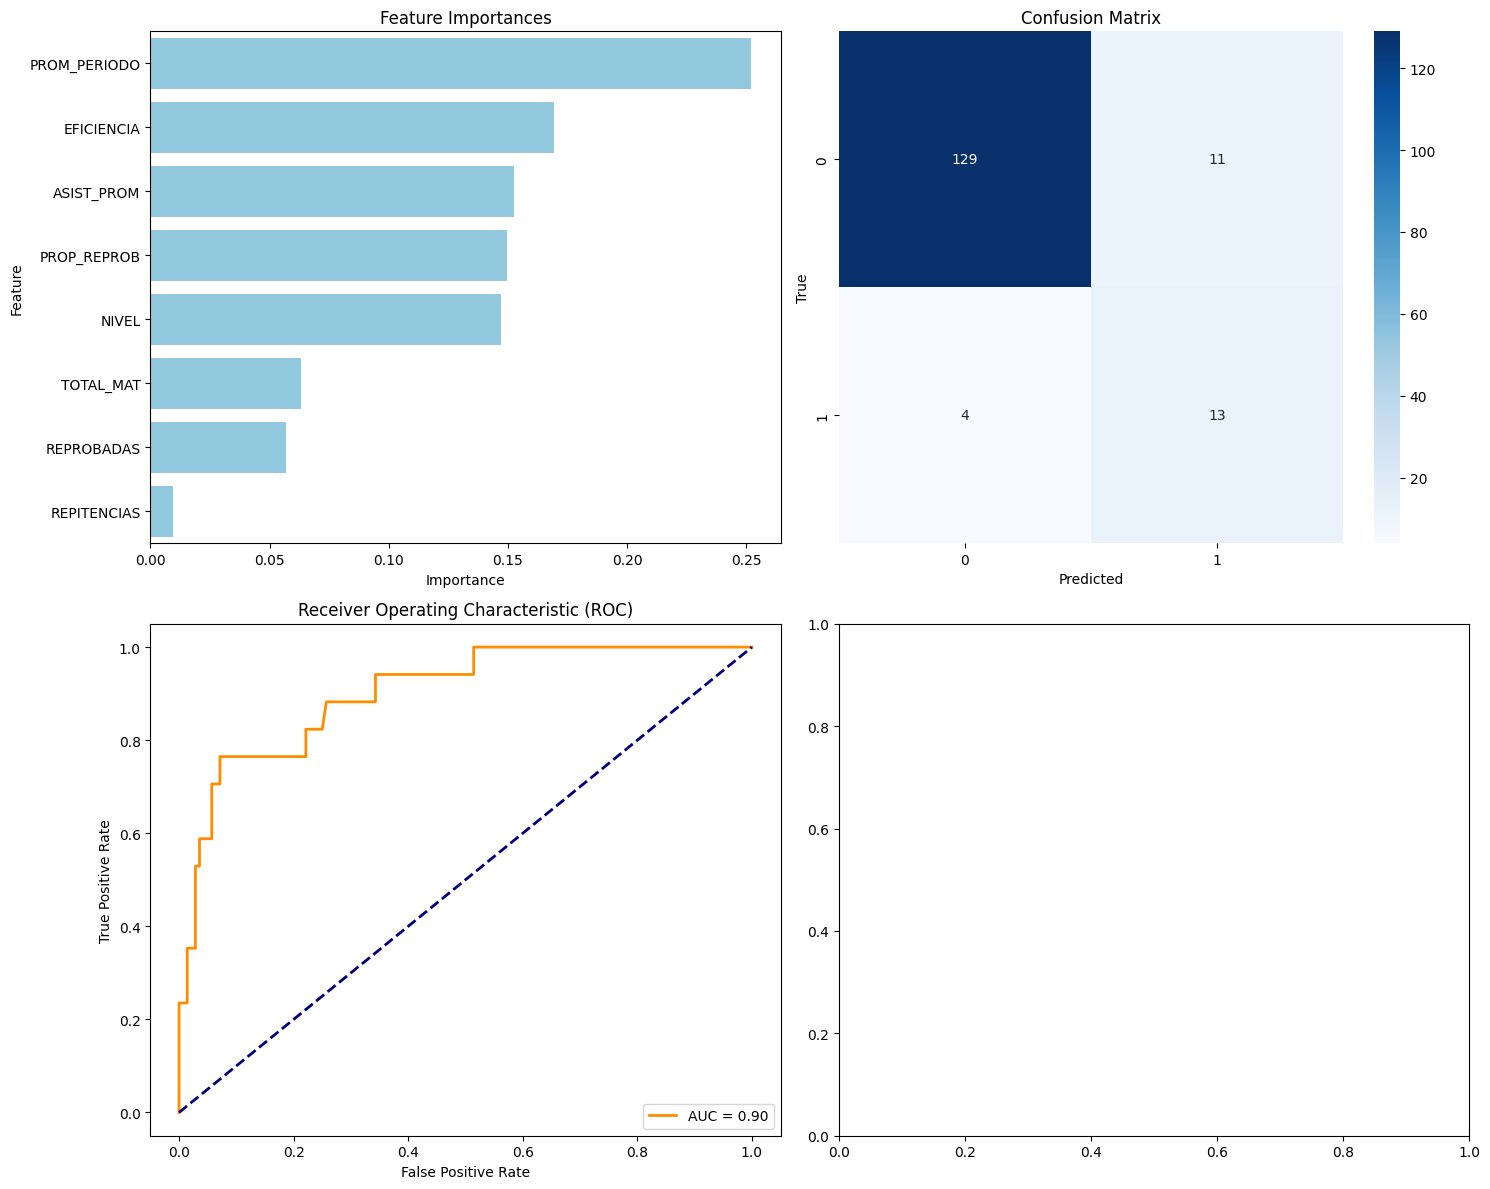

In [10]:
modelEvaluation(
    rf,
    df[features],
    df['RIESGO_t1'],
    X_test,
    y_test
    )

In [11]:
y_proba = rf.predict_proba(X_test)[:, 1]

Selected threshold: 0.53

Recall (dropout): 0.76
Precision: 0.57
F1-score: 0.65
Balanced Accuracy: 0.85
ROC-AUC: 0.90

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       140
           1       0.57      0.76      0.65        17

    accuracy                           0.91       157
   macro avg       0.77      0.85      0.80       157
weighted avg       0.93      0.91      0.92       157



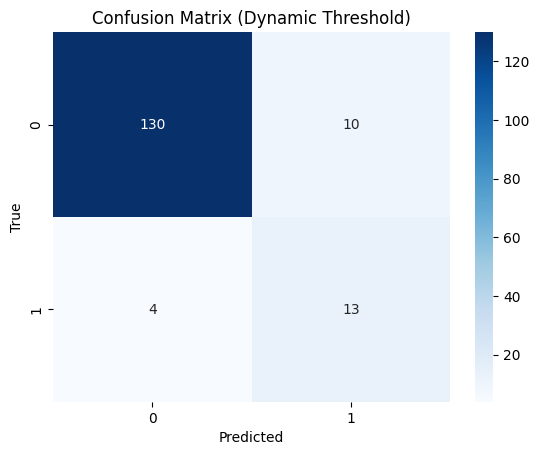

In [12]:
best_threshold = modelEvaluationWithThreshold(rf, X_train, y_train, X_test, y_test)

### Guardar modelo

In [13]:
artifact = {
    "model": rf,
    "threshold": best_threshold,
    "features": rf.named_steps['rf'].feature_names_in_,
    "model_version": "rf_dropout_v1"
}

joblib.dump(artifact, f"../../{MODEL_PATH}")

['../../artifacts/dropout_rf_v1.joblib']

El modelo entrenado y el umbral de decisión fueron almacenados conjuntamente como un único artefacto, permitiendo desacoplar el proceso de entrenamiento del proceso de inferencia. Esta estrategia garantiza la reproducibilidad de las predicciones y facilita la adaptación del sistema a distintos escenarios institucionales sin necesidad de reentrenar el modelo.